# IEEE Quantum Week - Bootstrapping a Quantum Computer - Part 1
#### @Thomas Alexander  & @Nate Earnest-Noble - Qiskit Slack 
#### @talexander2718 & @nathanearnestnoble - Github

In this tutorial we dive into tuning up a superconducting quantum computer using microwave pulses and Qiskit Pulse.

In [1]:
import sys
import warnings

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

import qiskit.tools.jupyter
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import SchedStyle

import fitting
import plotting

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
# Plotting style
style = SchedStyle(
    figsize=(6, 3), title_font_size=0, 
    axis_font_size=12, label_font_size=0, icon_font_size=8, 
    table_font_size=6, table_columns=1,
)

### Notebook information
This notebook uses [RISE](https://rise.readthedocs.io/en/stable/) for the slideshow. Please install if you want to use these features.

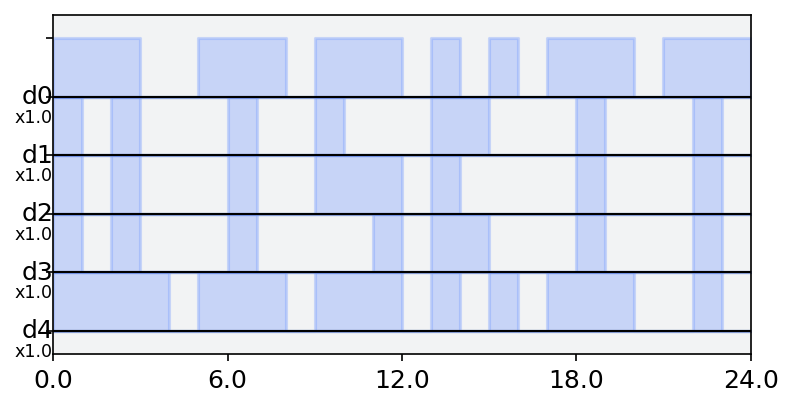

In [3]:
from qiskit import pulse

dc = pulse.DriveChannel
d0, d1, d2, d3, d4 = dc(0), dc(1), dc(2), dc(3), dc(4)

with pulse.build() as pulse_prog:  
    pulse.play([1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1], d0)
    pulse.play([1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0], d1)
    pulse.play([1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0], d2)
    pulse.play([1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0], d3)
    pulse.play([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0], d4)
pulse_prog.draw(style=style)

## Prelude
It should be possible to run this notebook with any backend that you have access to, although you may need to update some minor fitting parameters to make routines converge.

In [4]:
hub = 'ibm-q-community'
group = 'ieee-session'
project = 'main'
backend_name = 'ibmq_rome'

In [5]:
from qiskit import IBMQ
# load account credentials
IBMQ.load_account()
# load provider
provider = IBMQ.get_provider(hub=hub, group=group, project=project)
# Get our backend
backend = provider.get_backend(backend_name)

In [6]:
# configuration - Hardware configuration information.
config = backend.configuration()
# properties - Physical properties of the device.
properties = backend.properties()
# defaults - Information for pulse properties that change frequently.
defaults = backend.defaults()

In this tutorial we will focus only on qubits 0 and 1, although in practice we would need to repeat all one-qubit calibrations for each qubit, and two-qubit calibrations for each pair of coupled qubits.

In [7]:
qubits = [0, 1]

## Lets take a look at a Bell circuit

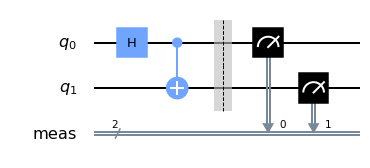

In [8]:
from qiskit.circuit import QuantumCircuit

bell_qc = QuantumCircuit(2)
bell_qc.h(0)
bell_qc.cx(0, 1)
bell_qc.measure_all()
bell_qc.draw(output='mpl')

This is a simple circuit containing two gates.

But how does this get implemented on this? 
<img src="quantum_computer.jpg" width=972 height=546 />

## With Qiskit it is easy to check
However, it is much harder to understand.

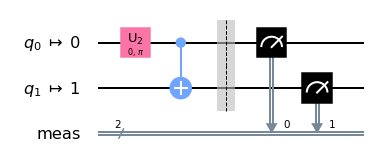

In [9]:
from qiskit import schedule, transpile

# We need to transpile the systems native gate set before scheduling.
bell_transpiled_qc = transpile(bell_qc, backend=backend)
bell_transpiled_qc.draw(output='mpl', idle_wires=False)

In [10]:
channels_to_exclude = [pulse.MeasureChannel(i) for i in range(2, 20)] + [pulse.AcquireChannel(i) for i in range(2, 20)]

## We can schedule at the level of microwave pulses

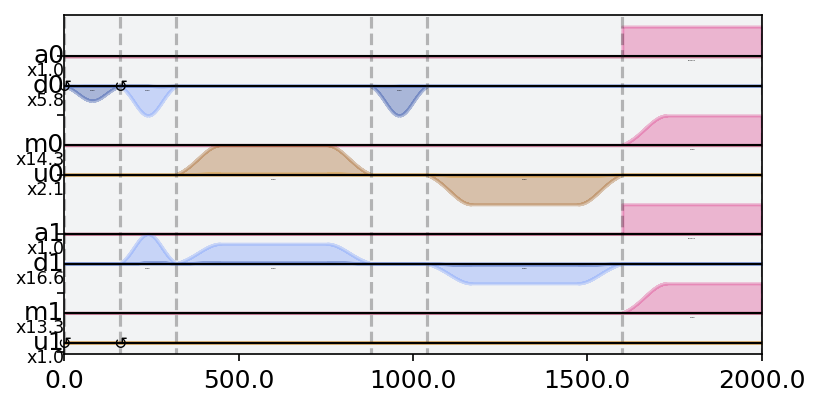

In [11]:
from qiskit import schedule

# We then schedule the output quantum circuit.
bell_sched = schedule(bell_transpiled_qc, backend=backend)

bell_sched.exclude(channels=channels_to_exclude).draw(label=True, style=style, plot_range=(0, 2000))

However, the above is much harder to understand.

- Below circuits, gates and measurements are *microcoded* as microwave pulses.
    - *Microcode is a computer hardware technique that interposes a layer of organisation between the CPU hardware and the programmer-visible instruction set architecture of the computer* - [Wikipedia](https://en.wikipedia.org/wiki/Microcode#)
- The requirements on the shape and timing/relative alignment of these pulses is very stringent and is an active field of research.
- These gates are calibrated often, many daily, to maintain performance.

In the rest of the notebook we will dive into how these parameters are found and how a device is bootstrapped into a quantum computer.

The only knowledge we will start with is a rough idea of the qubit frequencies (which in practice could be output from pre-fabrication simulations) and some rough parameters for our pulses that we know are approximately Ok for this class of devices.

# The qiskit pulse programming model

- Pulses are arrays of complex valued amplitudes or samples $[𝑑_0, …, 𝑑_𝑛]$
- Each sample is applied or played for time interval $dt$
- The pulse specifies an envelope that is mixed up with a carrier signal defined by a tuple $(𝑓_𝑖,𝜙_𝑖)$
- $𝑓_𝑖$ is the carrier signal’s frequency
- $𝜙_𝑖$ is the carrier signal’s phase or frame

<img src="pulse_model.png" width=648 height=364 />

### Pulse model
Consider a single qubit Hamiltonian
$$H/\hbar = -\frac{2\pi f_q}{2} \sigma_z + \Omega d[t]cos(2\pi f_d t - \phi)\sigma_x,$$
    
Where $\omega_q$ is the qubit 0->1 transition frequency, $\Omega$ is the constant of proportionality for the qubit drive strength, $d[t]$ a complex time-dependent pulse envelope, $\omega_d$ is the carrier drive frequency and $\phi$ is the phase of the carrier drive pulse.

$\omega_q$ and $\Omega$ are properties of the system whereas $d[t]$, $\omega_d$ and $\phi$ are knobs the user controls.

<img src="signal_mixing.png" width=972 height=546 />

### Theory's obfuscating - lets code :)
First we specify an envelope

In [12]:
duration = 100
sigma = 20
amp = 0.5
dt = 1e-10

In [13]:
timesteps = np.arange(0, duration)
times = timesteps*dt
envelope = amp*np.exp(-((timesteps-duration/2)/sigma)**2/2)

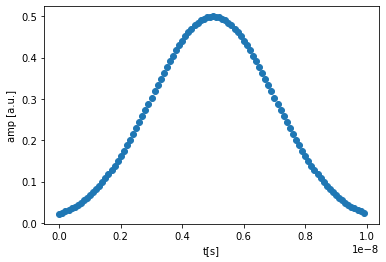

In [14]:
plt.scatter(times, envelope)
plt.xlabel('t[s]');
plt.ylabel('amp [a.u.]');

### Now a carrier

Note the phase of the carrier signal we control

In [15]:
freq = 5e9
phi = 0

In [16]:
carrier = np.exp(-1j*(freq*timesteps*dt+phi))

In [17]:
phi = np.pi/2

In [18]:
carrier_phased = np.exp(-1j*(freq*timesteps*dt + phi))

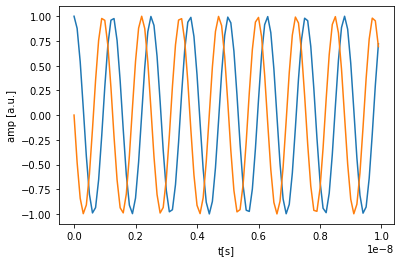

In [19]:
plt.plot(times, np.real(carrier))
plt.plot(times, np.real(carrier_phased))
plt.xlabel('t[s]');
plt.ylabel('amp [a.u.]');

### Mix them together
This is the signal the qubit sees. By controlling the phase we control the axis we drive the qubit around.

In [20]:
output_no_phase = carrier*envelope
output_phase = carrier_phased*envelope

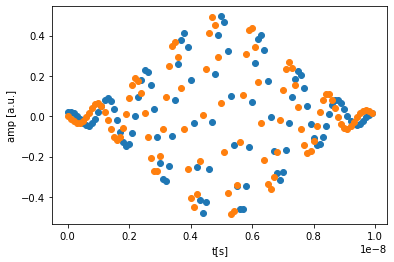

In [21]:
### Mix them together
output_no_phase = carrier*envelope
output_phase = carrier_phased*envelope

plt.scatter(times, np.real(output_no_phase))
plt.scatter(times, np.real(output_phase))
plt.xlabel('t[s]');
plt.ylabel('amp [a.u.]');

## Using Qiskit Pulse

In Qiskit we send pulses down to the qubit on a `pulse.PulseChannel`. There are three types of these and they are indexed:

In [22]:
pulse.DriveChannel(0);
pulse.MeasureChannel(0);
pulse.ControlChannel(0);

Envelopes are specified with `play` instructions in the [pulse builder interface](https://qiskit.org/documentation/apidoc/pulse.html?highlight=pulse#pulse-builder-builder).

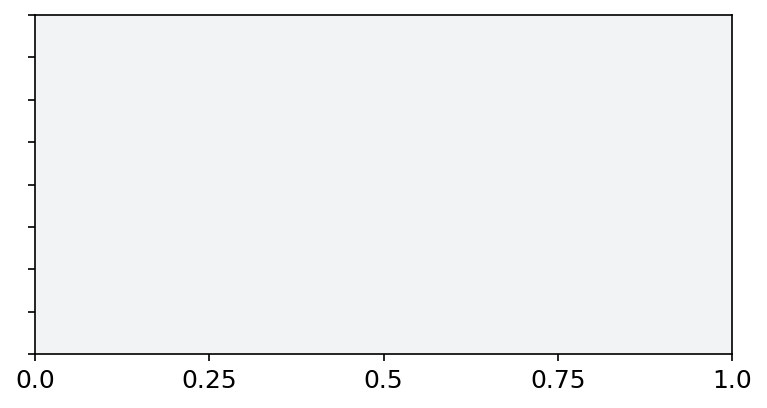

In [23]:
# Exercise
import numpy as np

d0 = pulse.DriveChannel(0)
m0 = pulse.MeasureChannel(0)

with pulse.build() as sched:
    # fill in the blanks Thomas!
    with pulse.align_sequential():
        pass

sched.draw(style=style)

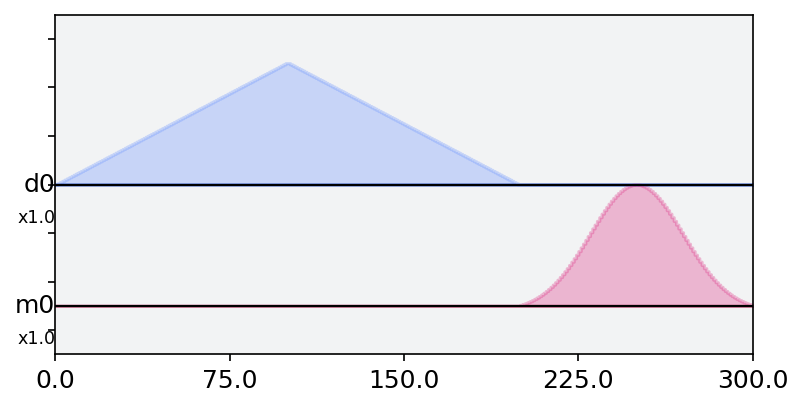

In [24]:
# Solution
import numpy as np

d0 = pulse.DriveChannel(0)
m0 = pulse.MeasureChannel(0)

with pulse.build() as sched:
    pulse.play(np.linspace(0, 1, 100), d0)
    pulse.play(np.linspace(1, 0, 100), d0)
    pulse.barrier(d0, m0)
    pulse.play(pulse.Gaussian(100, 1.0, 20), m0)

sched.draw(style=style)

The carrier can be controlled with instructions as well

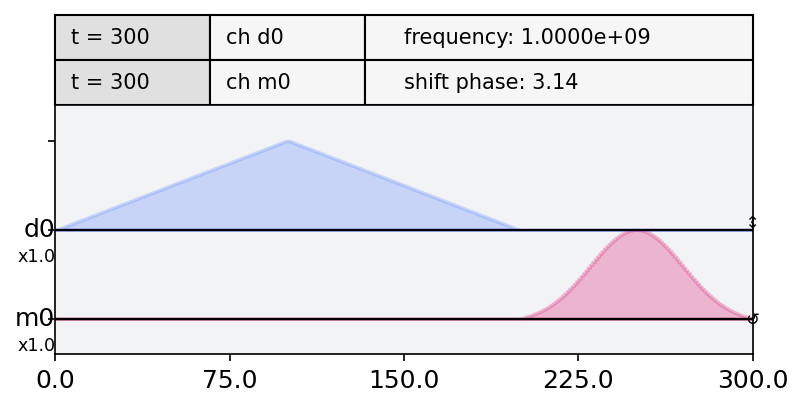

In [25]:
with pulse.build(schedule=sched) as sched:
    pulse.shift_frequency(1e9, d0)
    pulse.shift_phase(np.pi, m0)

sched.draw(style=style, table=True)

Measurements are a bit trickier as they involve a [weak measurement stimulus pulse to project the state of the qubit through a measurement resonator coupled to the qubit (Sec. VI)](https://arxiv.org/pdf/cond-mat/0402216.pdf). The shape of this stimulus pulse will be modified by the interaction with the qubit and be dependent on the state of the qubit. We can later fetch this data to see the result.

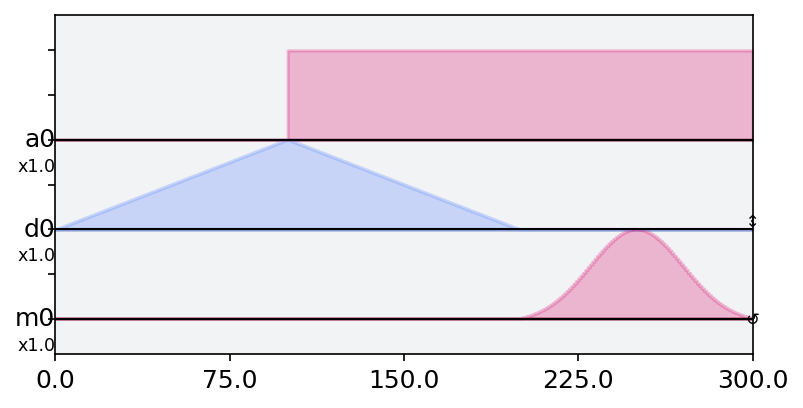

In [26]:
a0 = pulse.AcquireChannel(0)
mem_slot = pulse.MemorySlot(0)

with pulse.build() as measured_sched:
    with pulse.align_right():
        pulse.call(sched)
        pulse.acquire(200, a0, mem_slot)

measured_sched.draw(style=style)

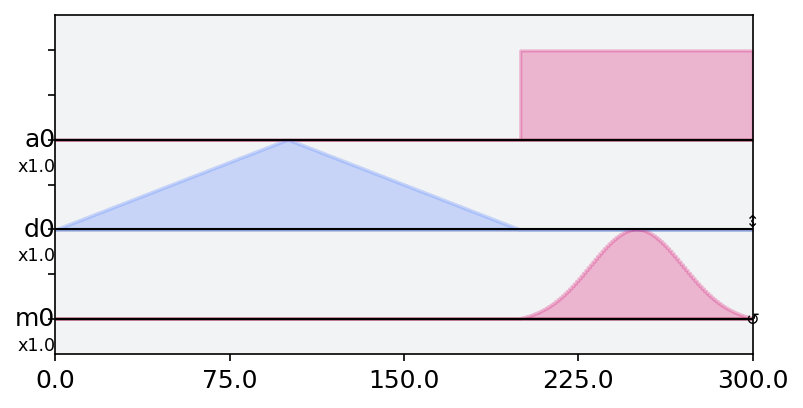

In [27]:
a0 = pulse.AcquireChannel(0)
mem_slot = pulse.MemorySlot(0)

with pulse.build() as measured_sched:
    with pulse.align_right():
        pulse.call(sched)
        pulse.acquire(100, a0, mem_slot)

measured_sched.draw(style=style)

<img src="quantum_chip.png" width=972 height=546 />

### Building our own rudimentary calibration framework
To use a quantum computer we must first bootstrap it from a bare device. We do this through a *calibration* process. Below we describe a very bare bones representation of our `Chip` calibration

We then populate this chip with information from our experiments in the rest of the notebook.

In [28]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
    
        
class Qubit(AttrDict):
    def __init__(self, index, attrs=None):
        self.index = index
        if attrs is None:
            attrs = AttrDict()
        
        self.attrs = attrs
    
    @classmethod
    def from_dict(cls, in_dict):
        return Qubit(in_dict['index'], attrs=AttrDict(**in_dict['attrs']))
     
    def to_dict(self):
        return {
            'index': self.index,
            'attrs': dict(self.attrs)
        }
    
    def __repr__(self):
        return "Qubit({0}, attrs={1})".format(self.index, self.attrs)


In [29]:
import json

class Chip:
    def __init__(self, qubits):
        self._qubits = {}
        for qubit in qubits:
            if isinstance(qubit, Qubit):
                self._qubits[qubit.index] = qubit
            else:
                self._qubits[qubit] = Qubit(qubit)
    
    @property
    def qubits(self):
        return list(self._qubits.values())
    
    @classmethod
    def load(cls, filepath):
        with open(filepath, 'r') as f:
            in_dict = json.load(f)
        
        return cls.from_dict(in_dict)
    
    @classmethod
    def from_dict(cls, in_dict):
        return Chip(Qubit.from_dict(qubit) for qubit in in_dict['qubits'])
        
    def save(self, filepath):
        with open(filepath, 'w') as f:
            json.dump(self.to_dict(), f)
    
    def to_dict(self):
        qubits = []
        for ind, qubit in self._qubits.items():
            qubits.append(qubit.to_dict())
        
        return {
            'qubits': qubits
        }

    def get_qubit(self, qubit):
        return self._qubits[qubit]
    
    def __repr__(self):
        return "Chip({})".format(repr(self.qubits)[1:-1])

In [30]:
chip = Chip(qubits)
chip

Chip(Qubit(0, attrs={}), Qubit(1, attrs={}))

We can save and load our chip to/from JSON.

In [31]:
chip.save('chip.json')
loaded_chip = Chip.load('chip.json')
loaded_chip

Chip(Qubit(0, attrs={}), Qubit(1, attrs={}))

If we had more time we would start to design a framework for experiments that would update our `Chip`s state.

What else would you want in a calibration framework?
    
    - Update times?
    - Gates?
    - A persistent database?
    - The ability to chain experiments?

Experiment for yourself

## We have knobs but now what?
As we saw above both the instructions and the *time* they happen at are crucial. 

How can we control a qubit with these knobs?

Let's see what happens if we make the time dependent transformation into the rotating frame of the qubit

$$H_{rot} = e^{it \frac{\omega_d}{2} \sigma_z} H e^{-it \frac{\omega_d}{2} \sigma_z} - \frac{\omega_d}{2}\sigma_z$$

Throwing fast oscillating terms (the rotating wave approximation) we will get.

$$H_{rot} = \frac{\omega_q-\omega_d}{2}\sigma_z + \frac{\Omega}{2} d[t] [\cos(\phi)\sigma_x + \sin(\phi) \sigma_y]$$

What does this mean? By setting the drive frequency to be on resonance with the qubit transition $f_d=f_q$, we have $$H_{rot} = \frac{\Omega}{2} d[t] [\cos(\phi)\sigma_x + \sin(\phi) \sigma_y]$$

The qubit evolution will obey the schrodinger equation:
$$i\hbar \frac{d}{dt} |\Psi(t)> = H |\Psi(t)>$$

With the solution assuming a constant pulse $d[t] = A$ 

$$U(T) = e^{-i\frac{\Omega A T}{2}[\cos(\phi)\sigma_x + \sin(\phi) \sigma_y]}$$

Setting $\phi=0$, $\theta= \Omega A T$ we get $Rx(\theta) = e^{-i\theta\sigma_x/2}$ and with $\phi=\pi/2$ we get $Ry(\theta) = e^{-i\theta\sigma_y/2}$

This is universal control over our qubit! By choosing a series of pulses about the X and Y axis of the qubit we can perform an arbitrary rotation.

## Tuning Up Our Single-qubit Gateset

### Learning the Qubit Frequencies
Recall that to make our rotating frame transformation we must send in our pulses with $\omega_d = \omega_q$. To do this we must learn $\omega_q$. We can do this by sweeping the frequency of our tone that we use to disturb the qubit. The closer we are to qubit's frequency the more we will disturb it and excite it into its $|1>$ state. If we plot this response against frequency we will trace out a Lorentzian shape with the form:
$$\frac{AB}{\pi (B^2+(\omega_d - \omega_q)^2)} + C$$

The other parameters are related to other specifics of the superconducting chip, and measurement chain such as the coupling of the qubit to the signal line,the lifetime of the qubit and the strength of the amplification in the signal chain.

By choosing a fixed pulse envelope we may sweep our frequency to excite the qubit and then fit the data to extract this signal.

In [32]:
spectroscopy_fit_func = lambda x, A, q_freq, B, C: (A / np.pi) * (abs(B) / ((x - q_freq)**2 + B**2)) + C

### Some input parameters for our initial experiments

In [33]:
num_exps = 50

perturbation = 1e7 # perturbs around known values to make non-trivial
freq_guesses = [freq + np.random.random()*perturbation for freq in defaults.qubit_freq_est]

freq_bandwidth = 15e7 # 10 MHz sweep

# Some reasonable guesses for a saturation pulse
spec_duration = 320
spec_amp = 0.02
spec_width = 260
spec_sigma = 20

# Some reasonable guesses for a measurement pulse
meas_duration = 16000
meas_amp = 0.15
meas_width = 15744
meas_sigma = 64

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

In [34]:
spec_pulse = pulse.GaussianSquare(spec_duration, spec_amp, spec_sigma, spec_width)
meas_pulse = pulse.GaussianSquare(meas_duration, meas_amp, meas_sigma, meas_width)

### Some helper functions for accessing channels

In [35]:
d = lambda idx: pulse.DriveChannel(idx)
m = lambda idx: pulse.MeasureChannel(idx)
u = lambda idx: pulse.ControlChannel(idx)
a = lambda idx: pulse.AcquireChannel(idx)
mem_slot = lambda idx: pulse.MemorySlot(idx) 

In [36]:
channels_to_plot = [d(0), d(1), m(0), m(1), a(0), a(1)]

In [37]:
qubit_freqs = {
    qubit.index: np.linspace(
        freq_guesses[qubit.index]-freq_bandwidth/2, 
        freq_guesses[qubit.index]+freq_bandwidth/2, 
        num_exps
    ) for qubit in chip.qubits
}

In [38]:
# Fill in the blanks!
def generate_spect_exps():
    spect_exps = []

    for i in range (num_exps):
        with pulse.build(backend=backend) as spect_exp:
            for qubit in chip.qubits:
                # set the frequency and manipulate qubit
                pass
            # add a barrier

            for qubit in chip.qubits:
                # add our measurement stimulus pulse
                pass
            # Need to acquire all qubits due to backend constraint
            for qubit in range(pulse.num_qubits()):
                # Acquire our qubits
                pass
        spect_exps.append(spect_exp)
    return spect_exps

In [39]:
# Solution
def generate_spect_exps():
    spect_exps = []

    for i in range(num_exps):
        with pulse.build(backend=backend) as spect_exp:
            for qubit in chip.qubits:
                pulse.set_frequency(qubit_freqs[qubit.index][i], d(qubit.index))
                pulse.play(spec_pulse, d(qubit.index))

            pulse.barrier(*range(pulse.num_qubits()))

            for qubit in chip.qubits:
                pulse.play(meas_pulse, m(qubit.index))

            # Need to acquire all qubits due to backend constraint
            for qubit in range(pulse.num_qubits()):
                pulse.acquire(meas_duration, a(qubit), mem_slot(qubit))

        spect_exps.append(spect_exp)
    return spect_exps

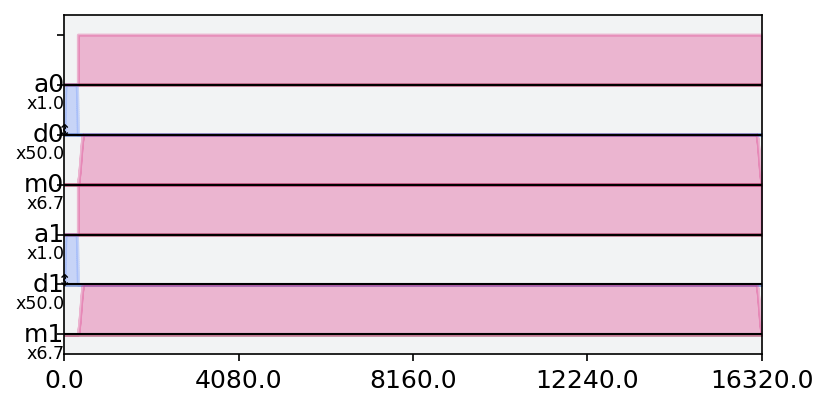

In [40]:
spect_exps = generate_spect_exps()
spect_exps[-1].draw(style=style, channels=channels_to_plot)

In [41]:
from qiskit import execute

spec_job = execute(generate_spect_exps(), backend, meas_level=1, shots=1024)
print(spec_job.job_id())
job_monitor(spec_job)

5f8597a4471ef10019c0ead4
Job Status: job has successfully run


In [42]:
spec_results = spec_job.result()

In [43]:
def extract_spect_data(qubit, result):
    sweep_values = []
    for i in range(len(result.results)):
        # Get the results from the ith experiment
        res = result.get_memory(i)*scale_factor
        # Get the results for `qubit` from this experiment
        sweep_values.append(res[qubit])

    spec_values = np.real(sweep_values)
    return spec_values

def fit_spect_exp(freqs, values):
    guess = [
        np.amax(values)-np.amin(values), # A 
        freqs[len(freqs)//2], # w_q
        0.05, # B
        np.mean(values) # C
    ]

    return fitting.fit_function(
        freqs,
        np.real(values), 
        spectroscopy_fit_func,
        guess,
    )

Frequency of qubit 0 is 4.968064556396592 GHz
Frequency of qubit 1 is 4.770241521498985 GHz


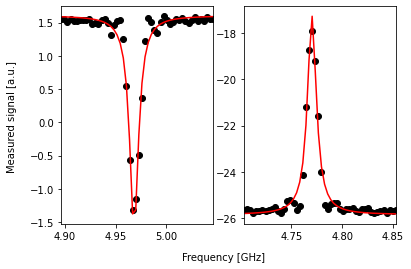

In [44]:
fig, axs = plt.subplots(int(min(np.ceil(len(qubits)/2), 1)), 2)
axs.reshape(-1)

for qubit, ax in zip(qubits, axs):
    spec_values = extract_spect_data(qubit, spec_results)
    freqs = qubit_freqs[qubit] / 1e9
    fit_params, fit_data = fit_spect_exp(freqs, spec_values)
    
    qubit_freq = fit_params[1]
    print('Frequency of qubit {0} is {1} GHz'.format(qubit, qubit_freq))
    chip.get_qubit(qubit).attrs.w0_1 = qubit_freq * 1e9
    ax.plot(freqs, fit_data, color='red')
    ax.scatter(freqs, spec_values, color='black') # plot real part of sweep values
    ax.set_xlim([min(freqs), max(freqs)])

fig.text(0.5, 0.0, 'Frequency [GHz]', ha='center')
fig.text(0.00, 0.5, 'Measured signal [a.u.]', va='center', rotation='vertical')
plt.show()

In [45]:
chip

Chip(Qubit(0, attrs={'w0_1': 4968064556.396592}), Qubit(1, attrs={'w0_1': 4770241521.498985}))

### Running a Rabi experiment
Here we set the phase of our carrier $\phi=0$ and obtain $R_x(A) = e^{-i\frac{\Omega A T}{2}\cos(\phi)\sigma_x}$ for some fixed evolution time $T$. We use a `gaussian` pulse to avoid exciting higher energy levels that exist in our system that weren't included in our analysis above.

In [46]:
x90_dur = 10*16
x90_sigma = 40
max_amp = 0.5
n_rabi_exps = 50

In [47]:
for qubit in chip.qubits:
    qubit.attrs.x90_dur = x90_dur
    qubit.attrs.x90_sigma = x90_sigma

chip

Chip(Qubit(0, attrs={'w0_1': 4968064556.396592, 'x90_dur': 160, 'x90_sigma': 40}), Qubit(1, attrs={'w0_1': 4770241521.498985, 'x90_dur': 160, 'x90_sigma': 40}))

In [48]:
chip.qubits

[Qubit(0, attrs={'w0_1': 4968064556.396592, 'x90_dur': 160, 'x90_sigma': 40}),
 Qubit(1, attrs={'w0_1': 4770241521.498985, 'x90_dur': 160, 'x90_sigma': 40})]

In [49]:
# Excercise

rabi_exps = []
amps = np.linspace(0, max_amp, n_rabi_exps)

for amp in amps:
    with pulse.build(backend=backend) as rabi_exp:
        x90 = pulse.Gaussian(x90_dur, amp, x90_sigma)

        for qubit in chip.qubits:
            # Set frequency
            # play Rabi pulse
            pass
        # Barrier
        # Measure
    rabi_exps.append(rabi_exp)

In [50]:
# Solution

rabi_exps = []
amps = np.linspace(0, max_amp, n_rabi_exps)

for amp in amps:
    with pulse.build(backend=backend) as rabi_exp:
        # build Rabi pulse
        rabi_pulse = pulse.Gaussian(x90_dur, amp, x90_sigma)
        for qubit in chip.qubits:
            # Set frequency
            # play Rabi pulse
            pulse.set_frequency(qubit.attrs.w0_1, d(qubit.index))
            pulse.play(rabi_pulse, d(qubit.index))
        # Barrier
        pulse.barrier(*qubits)
        # Measure
        pulse.measure(qubits)
    rabi_exps.append(rabi_exp)
        

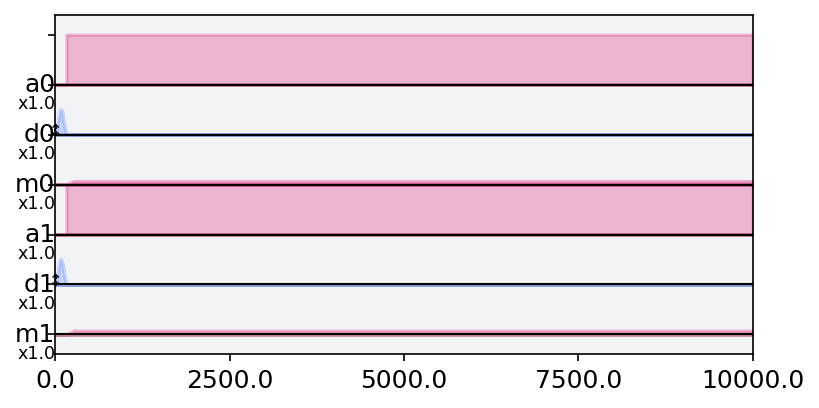

In [51]:
rabi_exps[-1].exclude(instruction_types=[pulse.SetFrequency]).draw(style=style, plot_range=(0, 10000), scale=1.0, channels=channels_to_plot)

### Run our experiment

In [52]:
from qiskit import execute

rabi_job = execute(rabi_exps, backend, meas_level=1, shots=256)
print(rabi_job.job_id())
job_monitor(rabi_job)

5f8597f2471ef10019c0ead9
Job Status: job has successfully run


In [53]:
rabi_result = rabi_job.result()

In [54]:
rabi_fit_func = lambda x, A, B, drive_period, phi: (A * np.cos(2 * np.pi * x / drive_period - phi) + B)

In [55]:
def fit_x90_and_plot(result, qubit, amps, ax):
    rabi_values = []
    for i, _ in enumerate(amps):
        # Get the results for `qubit` from the ith experiment
        rabi_values.append(result.get_memory(i)[qubit]*scale_factor)

    rabi_values = np.real(rabi_values)
    
    fit_params, y_fit = fitting.fit_function(
        amps,
        rabi_values, 
        rabi_fit_func,
        [(np.amax(rabi_values)-np.amin(rabi_values)), 0, 0.25, 0]
    )
    
    drive_period = abs(fit_params[2]) # get period of rabi oscillation

    plt.axvline(0, color='red', linestyle='--')
    plt.axvline(drive_period / 2 , color='red', linestyle='--')
    plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
    plt.xlabel("Drive amp [a.u.]", fontsize=15)
    plt.ylabel("Measured signal [a.u.]", fontsize=15)
    
    ax.plot(amps, y_fit, color='red')
    ax.scatter(amps, rabi_values, color='black') # plot real part of Rabi values
    return drive_period/4
    

### Plot our results

The pi/2 pulse amplitude for qubit 0 is: 0.0863890116508783
The pi/2 pulse amplitude for qubit 1 is: 0.06016207217310312


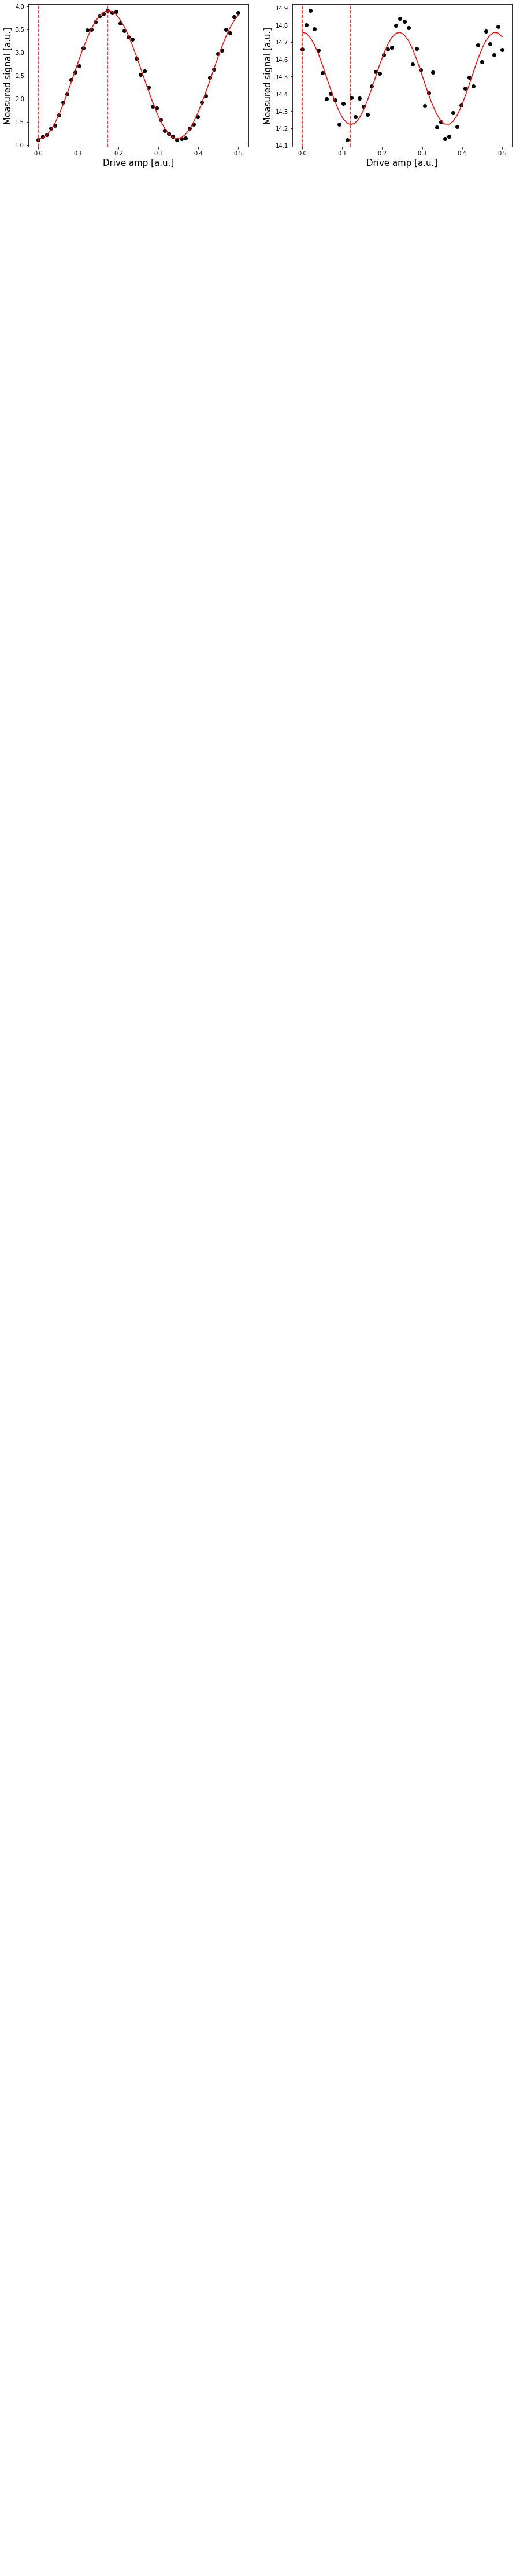

In [56]:
plt.figure(figsize=(15, 10))
q_offset = 0

x90_amps = []
for qubit in chip.qubits:
    ax = plt.subplot(2, 2, qubit.index + 1)
    x90_amp = fit_x90_and_plot(rabi_result, qubit.index, amps, ax)
    print("The pi/2 pulse amplitude for qubit {} is: {}".format(qubit.index, x90_amp))
    qubit.attrs.x90_amp = x90_amp
    x90_amps.append(x90_amp)
plt.show()

In [57]:
chip

Chip(Qubit(0, attrs={'w0_1': 4968064556.396592, 'x90_dur': 160, 'x90_sigma': 40, 'x90_amp': 0.0863890116508783}), Qubit(1, attrs={'w0_1': 4770241521.498985, 'x90_dur': 160, 'x90_sigma': 40, 'x90_amp': 0.06016207217310312}))

## Defining our gates
In Qiskit Pulse we store our calibrated gates in a library of calibrations.

Below we create an empty library which we will then populate.

In [58]:
inst_map = pulse.InstructionScheduleMap()

Next we define a simple helper function to make our code cleaner

In [59]:
import functools

# decorator generator
# takes the name of the gate, backend and inst_map
def cal(name, qubits, backend, inst_map=None):
    if inst_map is None:
        inst_map = backend.defaults().instruction_schedule_map
    
    # decorator for calibration function
    def wrapper(func):
        @functools.wraps(func)
        def inst_map_wrapper(*args, **kwargs):
            # activate the pulse builder before calling the function
            with pulse.build(backend=backend) as gate:
                output = func(*args, **kwargs)
            return gate
                    
        # register the built sequence
        inst_map.add(name, qubits, inst_map_wrapper)
        return inst_map_wrapper
    return wrapper

### Virtual Z-Gate
As we saw above incrementing the phase of carrier signal $\phi' = \phi+\pi/2$ will rotate a $\sigma_x -> \sigma_y$ and vice versa. Provided this phase is persistent (ie., for all pulses after it is incremented) this is equivalent to a $R_z(\phi)$. We can get our rotation around the Z-axis virtually for free if we track the phase in hardware. 

This means we only have to calibrate a single pulse with the identity:
$$U(\theta, \phi, \lambda) = R_z(\phi-\pi/2)R_x(\pi/2)R_z(\pi-\theta)R_x(\pi/2)R_z(\lambda-\pi/2)$$

This is known as a [virtual Z-Gate - arxiv.org/1612.00858](https://arxiv.org/pdf/1612.00858.pdf).

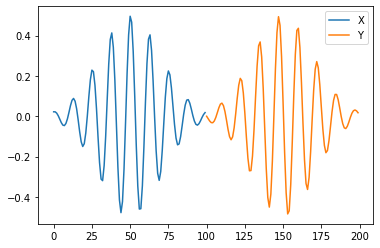

In [60]:
# Recall our phased pulses earlier
plt.plot(range(len(output_no_phase)), output_no_phase.real, label='X')
plt.plot(range(len(output_phase), 2*len(output_phase)), output_phase.real, label='Y')
plt.legend()

Rather than specify a new waveform with an envelope and sideband for each pulse of a given phase and frequency. It is more efficient and convenient to have the hardware track these values with the `set_phase` and `set_frequency` instructions provided in Qiskit. Below we show how we can define the virtual-Z gate. for our qubits.

Defining our virtual Z gate

In [61]:
# Fill in the blanks
@cal('rz', 0, backend, inst_map=inst_map)
def rz_q0(theta):
    theta = float(theta)
    # define virtual Z gate for qubit 0
    
@cal('rz', 1, backend, inst_map=inst_map)
def rz_q1(theta):
    theta = float(theta)
    # define virtual Z gate for qubit 0
            

In [62]:
# Solution
@cal('rz', 0, backend, inst_map=inst_map)
def rz_q0(theta):
    theta = float(theta)
    pulse.shift_phase(-theta, pulse.drive_channel(0))
    for chan in pulse.control_channels(0,  1):
        pulse.shift_phase(-theta, chan)
    
@cal('rz', 1, backend, inst_map=inst_map)
def rz_q1(theta):
    theta = float(theta)
    pulse.shift_phase(-theta, pulse.drive_channel(1))
    for chan in pulse.control_channels(1,  0):
        pulse.shift_phase(-theta, chan)

In [63]:
inst_map.get('rz', 1, np.pi/2)

Schedule((0, ShiftPhase(-1.5707963267948966, DriveChannel(1))), (0, ShiftPhase(-1.5707963267948966, ControlChannel(1))), name="sched1214")

# An $R_x(\theta)$ gate
Similar to the identity above we can create an $R_x(\theta)$ gate with the identity $R_x(\theta) = R_z(-\pi/2)R_x(\pi/2)R_z(\pi-\theta)R_x(\pi/2)R_z(-\pi/2)$.

Recall that our virtual Z-gates we have already defined. We will use them now.

In [64]:
def def_rx_gate(qubit):
    @cal('rx', qubit.index, backend, inst_map=inst_map)
    def rx(theta):
        x_90_pulse = pulse.Gaussian(qubit.attrs.x90_dur, qubit.attrs.x90_amp, qubit.attrs.x90_sigma)
        pulse.set_frequency(qubit.attrs.w0_1, d(qubit.index))
        theta = float(theta)
        pulse.call(inst_map.get('rz', qubit.index, -np.pi/2))
        pulse.play(x_90_pulse, d(qubit.index))
        pulse.call(inst_map.get('rz', qubit.index, np.pi-theta))
        pulse.play(x_90_pulse, d(qubit.index))
        pulse.call(inst_map.get('rz', qubit.index, -np.pi/2))


def_rx_gate(chip.qubits[0])
def_rx_gate(chip.qubits[1])

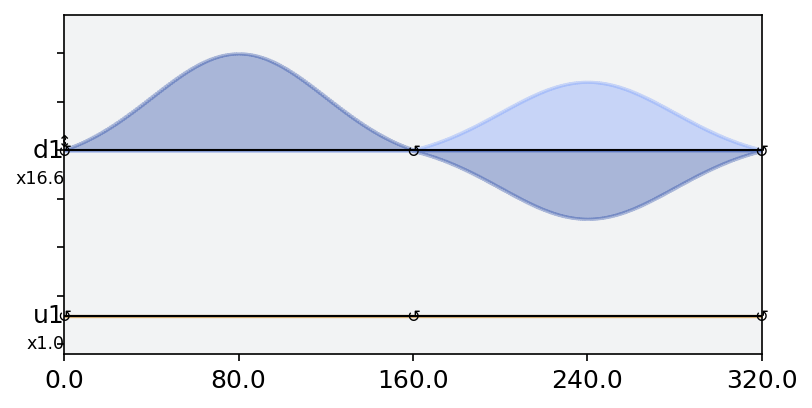

In [65]:
inst_map.get('rx', 1, np.pi/4).exclude(instruction_types=[pulse.SetFrequency]).draw(style=style)

We add an `x` gate to our basis set as it is easy, and useful for calibrating measurements.

In [66]:
def def_x_gate(qubit):
    @cal('x', qubit.index, backend, inst_map=inst_map)
    def x():
        x_180_pulse = pulse.Gaussian(qubit.attrs.x90_dur, 2 * qubit.attrs.x90_amp, qubit.attrs.x90_sigma)
        pulse.set_frequency(qubit.attrs.w0_1, d(qubit.index))
        pulse.play(x_180_pulse, pulse.drive_channel(qubit.index))
    return x

def_x_gate(chip.qubits[0]);  
def_x_gate(chip.qubits[1]);

## SU(2) control
With the identity 
$$U(\theta, \phi, \lambda) = R_z(\phi-\pi/2)R_x(\pi/2)R_z(\pi-\theta)R_x(\pi/2)R_z(\lambda-\pi/2)$$

Its clear we only need to tune up a single $R_x(\pi/2)$ pulse and use the virtual z-gate to get universal control over our qubits.

### We may also directly add the x90 gate
Up to a global phase $Rx(\pi/2) \equiv \sqrt{X}$ holds.

In [67]:
def def_sx_gate(qubit):
    @cal('sx', qubit.index, backend, inst_map=inst_map)
    def sx():
        dc = pulse.drive_channel(qubit.index)
        pulse.set_frequency(qubit.attrs.w0_1, dc)
        x_90_pulse = pulse.Gaussian(qubit.attrs.x90_dur, qubit.attrs.x90_amp, qubit.attrs.x90_sigma)
        
        pulse.play(x_90_pulse, dc)


def_sx_gate(chip.qubits[0])
def_sx_gate(chip.qubits[1])

## Exercise #1
We have now tuned up our single qubit basis gateset. However, there are many more properties about our qubits and our quantum chip we haven't learned. Let's save our current state and use it to learn some new parameters about our qubits.

In [68]:
chip.save('saved_chip_ex1.json')

Head to [Exercise #1 - Measuring Relaxation in Qubits](./Exercise%20%231%20-%20Measuring%20Relaxation%20in%20Qubits.ipynb) to complete the exercise for this session.

# IEEE Quantum Week - Bootstrapping a Quantum Computer - Part 2

Welcome back! We hope you had a good break and managed to complete the first exercise.

In this session we will complete our basis gate set for our 2 qubits by tuning up a CNOT gate.
We will then use this to prepare a Bell state, $|\Phi^+> = \frac{1}{\sqrt{2}} (|00> + |11>)$ 

<img src="cr_gate.png" width=1944 height=1092 />

### Building our Cross-Resonance Calibration Experiments

As Nate covered the cross-resonance gate in his lectures, I'm going to dive straight into calibrating it.

We do this with an experiment that is very similar to the Rabi experiment.

Recall our Hamiltonian will look like:
$$H_{cr}/\hbar = \Omega\epsilon(t)\left(\sigma_z\otimes\mathbb{1}+\nu\mathbb{1}\otimes\sigma_x+\mu\sigma_z\otimes\sigma_x\right)$$

$$\mu = \pm \frac{g}{\Delta_{12}}\frac{\alpha}{\alpha \mp \Delta_{12}}$$
$$\nu = \pm \frac{g}{\Delta_{12}}\frac{\mp \Delta_{12}}{\alpha_i \mp \Delta_{12}}$$

This means the effective Rabi strength will be

$$\Omega_{CR} = \Omega\epsilon(\nu+<\sigma_z\mathbb{1}>\mu)$$

In [69]:
cr_max_amp = 1.0
num_cr_exps = 35
cr_drive_amps = np.linspace(-cr_max_amp, cr_max_amp, num_cr_exps)

cr45_dur = 560
cr45_sigma = 64 
cr45_width = 304

In [70]:
for qubit in chip.qubits:
    qubit.attrs.cr45_dur = cr45_dur
    qubit.attrs.cr45_sigma = cr45_sigma
    qubit.attrs.cr45_width = cr45_width

chip

Chip(Qubit(0, attrs={'w0_1': 4968064556.396592, 'x90_dur': 160, 'x90_sigma': 40, 'x90_amp': 0.0863890116508783, 'cr45_dur': 560, 'cr45_sigma': 64, 'cr45_width': 304}), Qubit(1, attrs={'w0_1': 4770241521.498985, 'x90_dur': 160, 'x90_sigma': 40, 'x90_amp': 0.06016207217310312, 'cr45_dur': 560, 'cr45_sigma': 64, 'cr45_width': 304}))

### Build the CR Rabi Experiment

In [71]:
def build_cr_rabi_exps(control, target, flip_drive=False):
    cr_exps = []
    for i, cr_drive_amp in enumerate(cr_drive_amps):
        with pulse.build(backend=backend) as cr_exp: 
            # flip drive qubit if desired
            if flip_drive:
                pulse.call(inst_map.get('x', (control.index, )))
            
            pulse.barrier(control.index)
            cr_rabi_pulse = pulse.GaussianSquare(
                duration=cr45_dur, 
                amp=cr_drive_amp, 
                sigma=cr45_sigma,
                width=cr45_width,
            )
            cr_chan = pulse.control_channels(control.index, target.index)[0]
            pulse.set_frequency(target.attrs.w0_1, cr_chan)
            pulse.play(cr_rabi_pulse, cr_chan)

            pulse.barrier(control.index, target.index)
            pulse.measure([control.index, target.index])

        cr_exps.append(cr_exp)
    return cr_exps

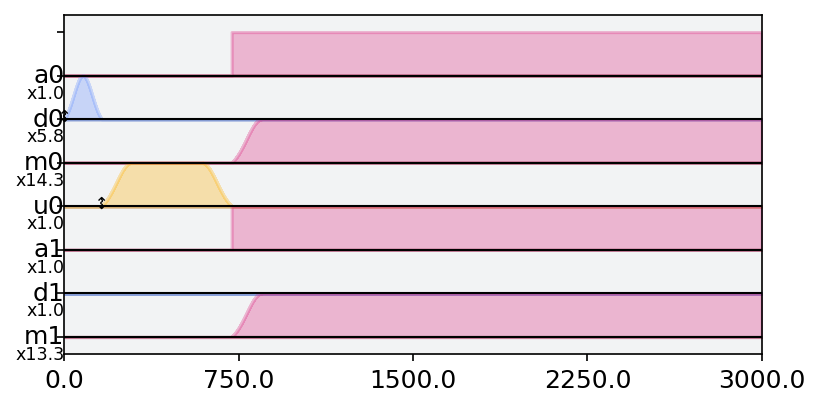

In [72]:
cr_rabi_01_exps_no_flip = build_cr_rabi_exps(chip.qubits[0], chip.qubits[1], flip_drive=False)
cr_rabi_01_exps_flip = build_cr_rabi_exps(chip.qubits[0], chip.qubits[1], flip_drive=True)
cr_rabi_01_exps_flip[-1].exclude(instruction_types=[pulse.SetFrequency]).draw(style=style, plot_range=(0, 3000), channels=channels_to_plot+[u(0)])

### Run the CR Experiments

In [73]:
cr_rabi_01_job = execute(cr_rabi_01_exps_no_flip+cr_rabi_01_exps_flip, backend, meas_level=1, meas_return='avg', shots=2048)

print(cr_rabi_01_job.job_id())

job_monitor(cr_rabi_01_job)

5f85987683c0ff0019f25e73
Job Status: job has successfully run


In [74]:
cr_rabi_01_results = cr_rabi_01_job.result()

In [75]:
def fit_cr45_and_plot(result, control, target, amps, legend=True): 
    # extract data
    control_values_no_flip, control_values_flip = fitting.extract_cr_data(
        control, result, num_cr_exps, scale_factor
    )

    target_values_no_flip, target_values_flip = fitting.extract_cr_data(
        target, result, num_cr_exps, scale_factor
    )
    
    # fit data
    fit_params_no_flip, target_fit_no_flip = fitting.fit_function(
        amps,
        target_values_no_flip, 
        rabi_fit_func,
        [(np.amax(target_values_no_flip)-np.amin(target_values_no_flip)), np.mean(target_values_no_flip), 1., 0]
    )
    
    fit_params_flip, target_fit_flip = fitting.fit_function(
        amps,
        target_values_flip, 
        rabi_fit_func,
        [(np.amax(target_values_flip)-np.amin(target_values_flip)), np.mean(target_values_flip), 1., 0]
    )
    
    # plot data
    plotting.plot_cr45(
        amps,
        control_values_no_flip, control_values_flip, 
        target_values_no_flip, target_values_flip, 
        target_fit_no_flip, target_fit_flip,
    )
    amp = abs(fit_params_no_flip[-2] / 4)
    return amp

### Analyze our results and $CR(\pi/2)$ amplitudes

The pi/4 pulse amplitude for the CR45p gate between qubits 0 and 1 is: 0.4747837879906288


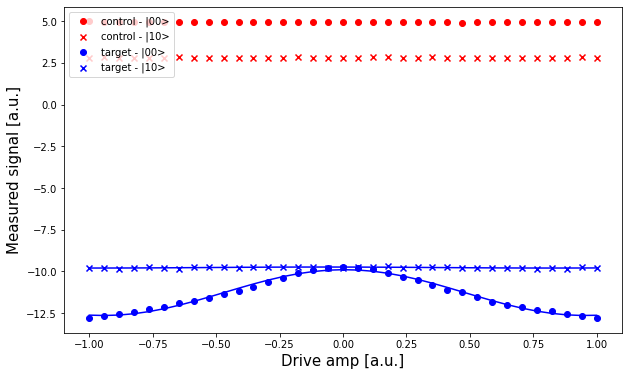

In [76]:
plt.figure(figsize=(10, 6))
q_offset = 0

ax = plt.subplot(1, 1, 1)

cr45_q0q1_amp = fit_cr45_and_plot(cr_rabi_01_results, 0, 1, cr_drive_amps, ax)
chip.qubits[0].attrs.cr45_q0q1_amp = cr45_q0q1_amp
print("The pi/4 pulse amplitude for the CR45p gate between qubits 0 and 1 is: {}".format(cr45_q0q1_amp))
plt.show()

### From this pulse we can construct our CNOT gate

$$U_{CR_\theta} = e^{-i\frac{\theta}{2} \sigma_z \sigma_x}$$

With the CNOT defined as below

In [77]:
from qiskit.circuit import Gate

cr = Gate('Ucr', 2, [-np.pi/2])
cx_circ = QuantumCircuit(2)
cx_circ.rz(np.pi/2, 0)
cx_circ.rx(np.pi/2, 1)
cx_circ.append(cr, (0, 1))
cx_circ.draw()

┌──────────┐┌─────────────┐
q_0: ┤ RZ(pi/2) ├┤0            ├
     ├──────────┤│  Ucr(-pi/2) │
q_1: ┤ RX(pi/2) ├┤1            ├
     └──────────┘└─────────────┘

### Construct our CNOT Gates

In [78]:
# Exercise - Define our CX gate
def def_cx_gate(control, target):
    
    @cal('cx', (control.index, target.index), backend, inst_map=inst_map)
    def cx():
        cr45p_amp = control.attrs[
            'cr45_q{0}q{1}_amp'.format(control.index, target.index)
        ]
        
        cr90m = pulse.GaussianSquare(
            control.attrs.cr45_dur, 
            -2 * cr45p_amp, 
            control.attrs.cr45_sigma, 
            control.attrs.cr45_width,
        )
        
        # rz(pi/2)⊗I . I⊗rx(pi/2) . Ucr_90
        pulse.call(inst_map.get('rz', 0, np.pi/2))
        pulse.call(inst_map.get('rx', 1, np.pi/2))
        pulse.barrier(control.index, target.index)
        cr_chan = pulse.control_channels(control.index, target.index)[0]
        pulse.play(cr90m, cr_chan)
    return cx


def_cx_gate(chip.qubits[0], chip.qubits[1]);

In [79]:
# Solution
def def_cx_gate(control, target):
    
    @cal('cx', (control.index, target.index), backend, inst_map=inst_map)
    def cx():
        cr45p_amp = control.attrs[
            'cr45_q{0}q{1}_amp'.format(control.index, target.index)
        ]
        
        cr90m = pulse.GaussianSquare(
            control.attrs.cr45_dur, 
            -2 * cr45p_amp, 
            control.attrs.cr45_sigma, 
            control.attrs.cr45_width,
        )
        
        pulse.call(inst_map.get('rz', control.index, np.pi/2))
        pulse.call(inst_map.get('rx', target.index, np.pi/2))
        pulse.barrier(control.index, target.index) 
        pulse.play(cr90m, pulse.control_channels(control.index, target.index)[0])   

    return cx


def_cx_gate(chip.qubits[0], chip.qubits[1]);

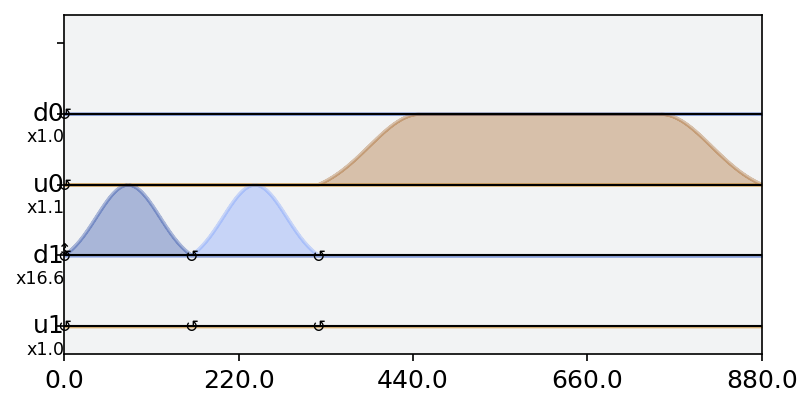

In [80]:
inst_map.get('cx', (0,1)).exclude(instruction_types=[pulse.SetFrequency]).draw(style=style)

### Finally grab the measurement from the backend

You'll learn more about this in the second exercise.

In [81]:
inst_map.add('measure', range(config.n_qubits), 
             defaults.instruction_schedule_map.get('measure', range(config.n_qubits)))

## Now we have defined our basis gateset!

In [82]:
config.basis_gates

['id', 'u1', 'u2', 'u3', 'cx']

In [83]:
basis_gates = ['rz', 'sx', 'cx', 'x']

## Returning to our Bell state

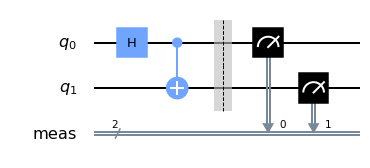

In [84]:
bell_qc.draw(output='mpl')

In [85]:
basis_gates

['rz', 'sx', 'cx', 'x']

In [86]:
inst_map.instructions

['rz', 'rx', 'x', 'sx', 'cx', 'measure']

### Our new transpiled circuit for our basis gateset

As of Qiskit v0.20 can now automatically figure out how to compile with our new basis gateset with its equivalence library

Its still not perfect at optimizing as we see below

In [87]:
# Exercise
# Transpile and plot our circuit with our new basis gateset
# We need to transpile the systems native gate set before scheduling.

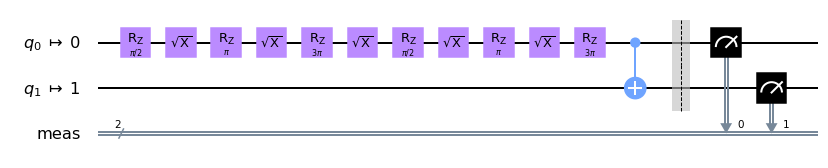

In [88]:
# Solution
# Transpile and plot our circuit with our new basis gateset
# We need to transpile the systems native gate set before scheduling.
custom_bell_transpiled_qc = transpile(bell_qc, backend=backend, basis_gates=basis_gates, optimization_level=3)
custom_bell_transpiled_qc.draw(output='mpl', idle_wires=False)

### Our new pulse schedule implementing the Bell state

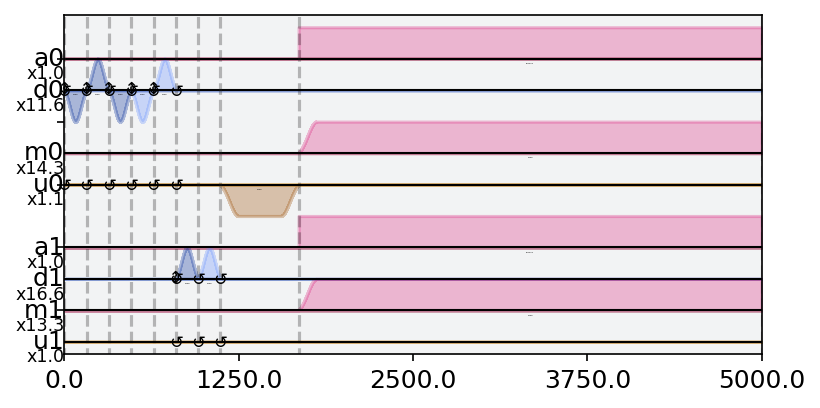

In [89]:
# We then schedule the output quantum circuit.
custom_bell_sched = schedule(custom_bell_transpiled_qc, backend=backend, inst_map=inst_map)

custom_bell_sched.exclude(channels=channels_to_exclude).exclude(instruction_types=[pulse.SetFrequency]).draw(label=True, style=style, plot_range=(0, 5000))

## Let's compare our results

In [90]:
bell_job = execute([bell_sched, custom_bell_sched], backend, meas_level=2, shots=512)

print(bell_job.job_id())
job_monitor(bell_job)

5f85998f764d690019635c3e
Job Status: job has successfully run


In [91]:
from qiskit.result.utils import marginal_counts
bell_result = marginal_counts(bell_job.result(), indices=qubits)

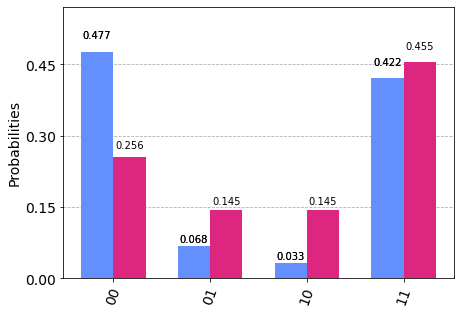

In [92]:
from qiskit.visualization import plot_histogram

bell_orig = bell_result.get_counts(0)
bell_new = bell_result.get_counts(1)
plot_histogram([bell_orig, bell_new])

## We didn't do so well. How come?
Well to start with look at our Hadamard decomposition? Is horribly long!

In Qiskit we can teach the compiler how to perform this decomposition better!

In [93]:
from qiskit.circuit.library.standard_gates.equivalence_library import StandardEquivalenceLibrary

In [94]:
help(StandardEquivalenceLibrary)

Help on EquivalenceLibrary in module qiskit.circuit.equivalence object:

class EquivalenceLibrary(builtins.object)
 |  EquivalenceLibrary(*, base=None)
 |  
 |  A library providing a one-way mapping of Gates to their equivalent
 |  implementations as QuantumCircuits.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *, base=None)
 |      Create a new equivalence library.
 |      
 |      Args:
 |          base (Optional[EquivalenceLibrary]):  Base equivalence library to
 |              will be referenced if an entry is not found in this library.
 |  
 |  add_equivalence(self, gate, equivalent_circuit)
 |      Add a new equivalence to the library. Future queries for the Gate
 |      will include the given circuit, in addition to all existing equivalences
 |      (including those from base).
 |      
 |      Parameterized Gates (those including `qiskit.circuit.Parameters` in their
 |      `Gate.params`) can be marked equivalent to parameterized circuits,
 |      provided the paramet

### Define our H equivalence using Sx

In [95]:
# Exercise
from qiskit import QuantumRegister
from qiskit.circuit.library import HGate, RZGate, SXGate

def build_H_equivalence_circuit():
    """Use the identity H = RZ(pi/2).SX.RZ(pi/2)"""
    q = QuantumRegister(1, 'q')
    def_h = QuantumCircuit(q)
    # Add equivalence circuit here
    return def_h

In [96]:
# Solution
from qiskit import QuantumRegister
from qiskit.circuit.library import HGate, RZGate, SXGate

def build_H_equivalence_circuit():
    """Use the identity H = R_z(pi/2).SX.RZ(pi/2)"""
    q = QuantumRegister(1, 'q')
    def_h = QuantumCircuit(q)
    def_h.append(RZGate(np.pi / 2), [q[0]], [])
    def_h.append(SXGate(), [q[0]], [])
    def_h.append(RZGate(np.pi / 2), [q[0]], [])
    return def_h

In [97]:
StandardEquivalenceLibrary.add_equivalence(HGate(), build_H_equivalence_circuit())

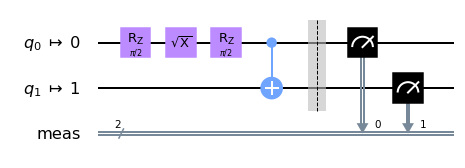

In [98]:
# We need to transpile the systems native gate set before scheduling.
custom_bell_transpiled_qc_hdecomp = transpile(bell_qc, backend=backend, basis_gates=basis_gates, optimization_level=3)
custom_bell_transpiled_qc_hdecomp.draw(output='mpl', idle_wires=False)

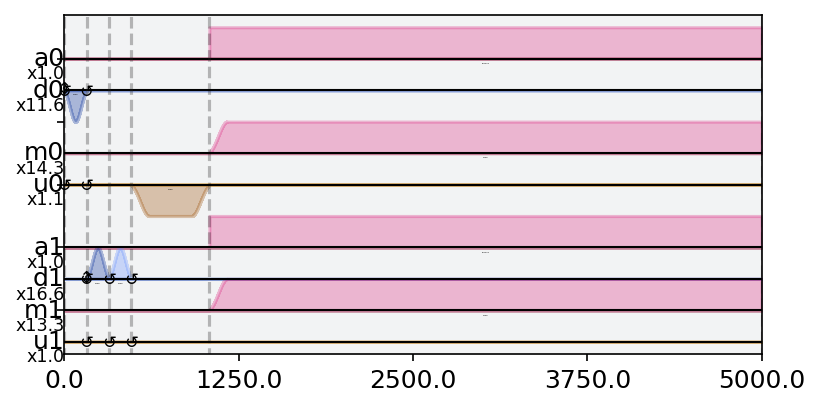

In [99]:
# We then schedule the output quantum circuit.
custom_bell_sched_hdecomp = schedule(custom_bell_transpiled_qc_hdecomp, backend=backend, inst_map=inst_map)

custom_bell_sched_hdecomp.exclude(channels=channels_to_exclude).exclude(instruction_types=[pulse.SetFrequency]).draw(label=True, style=style, plot_range=(0, 5000))

## Run our better Hadamard circuit

In [100]:
bell_job = execute([bell_sched, custom_bell_sched, custom_bell_sched_hdecomp], backend, meas_level=2, shots=512)

print(bell_job.job_id())

job_monitor(bell_job)

5f859a088c71b8001b04deb5
Job Status: job has successfully run


In [101]:
from qiskit.result.utils import marginal_counts

bell_result = marginal_counts(bell_job.result(), indices=qubits)

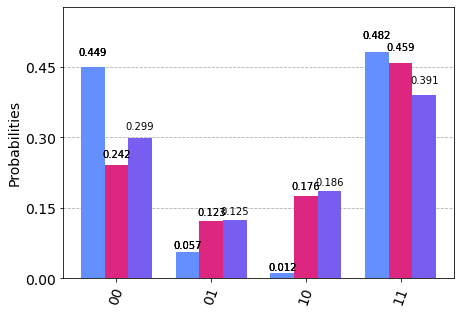

In [102]:
from qiskit.visualization import plot_histogram

bell_orig = bell_result.get_counts(0)
bell_new = bell_result.get_counts(1)
bell_new_h_decomp = bell_result.get_counts(2)
plot_histogram([bell_orig, bell_new, bell_new_h_decomp])

### Hmm, that wasn't quite it
It seems like most of our error isn't from the single-qubit gate.

It must be in our CNOT gate!

## What about our CNOT gate?

Well if we were to look at the components of our gate as a function of pulse amplitude we would get something like:

<img src="hamiltonian_tomography_cr.png" alt="CR process tomography" style="width: 500px;"/>

Data from [Qiskit pulse: programming quantum computers through the cloud with pulses](https://doi.org/10.1088/2058-9565/aba404)

### We can remove this with an echo
![spin echo](https://upload.wikimedia.org/wikipedia/commons/9/9b/HahnEcho_GWM.gif)
GavinMorley / CC BY-SA (https://creativecommons.org/licenses/by-sa/3.0)

Compare the two pulses
<img src="cnot_schedules.png" alt="CNOT schedules" style="width: 500px;"/>

In [103]:
# Exercise

def def_cx_gate(control, target):
    @cal('cx', (control.index, target.index), backend, inst_map=inst_map)
    def cx():
        cr45p_amp = control.attrs['cr45_q{0}q{1}_amp'.format(control.index, target.index)]
        
        cr45p = pulse.GaussianSquare(
            control.attrs.cr45_dur, cr45p_amp, control.attrs.cr45_sigma, control.attrs.cr45_width
        )
        
        cr45m = pulse.GaussianSquare(
            control.attrs.cr45_dur, -cr45p_amp, control.attrs.cr45_sigma, control.attrs.cr45_width,
        )
        # Compensation
        pulse.call(inst_map.get('rz', control.index, np.pi/2))
        pulse.call(inst_map.get('rx', target.index, np.pi/2))
        pulse.barrier(control.index, target.index)
        
        # Add an echo!
        cr_chan = pulse.control_channels(control.index, target.index)[0]
        pulse.barrier(control.index, target.index)
        
        # Play a CR45p pulse
        pulse.barrier(control.index, target.index)
        
        # Another echo!
        pulse.barrier(control.index, target.index)
        # Play a CR45p pulse

    return cx


def_cx_gate(chip.qubits[0], chip.qubits[1]);

In [104]:
# Solution

def def_cx_gate(control, target):
    @cal('cx', (control.index, target.index), backend, inst_map=inst_map)
    def cx():
        cr45p_amp = control.attrs['cr45_q{0}q{1}_amp'.format(control.index, target.index)]
        
        cr45p = pulse.GaussianSquare(
            control.attrs.cr45_dur, cr45p_amp, control.attrs.cr45_sigma, control.attrs.cr45_width
        )
        
        cr45m = pulse.GaussianSquare(
            control.attrs.cr45_dur, -cr45p_amp, control.attrs.cr45_sigma, control.attrs.cr45_width,
        )
        # Compensation
        pulse.call(inst_map.get('rz', control.index, np.pi/2))
        pulse.call(inst_map.get('rx', target.index, np.pi/2))
        # Echo
        pulse.call(inst_map.get('x', control.index))
        pulse.barrier(control.index, target.index)

        cr_chan = pulse.control_channels(control.index, target.index)[0]
        # CR45p
        pulse.play(cr45p, cr_chan)
        pulse.barrier(control.index, target.index)
        # Echo
        pulse.call(inst_map.get('x', control.index))
        pulse.barrier(control.index, target.index)
        # CR45m
        pulse.play(cr45m, cr_chan)
        pulse.barrier(control.index, target.index)

    return cx


def_cx_gate(chip.qubits[0], chip.qubits[1]);

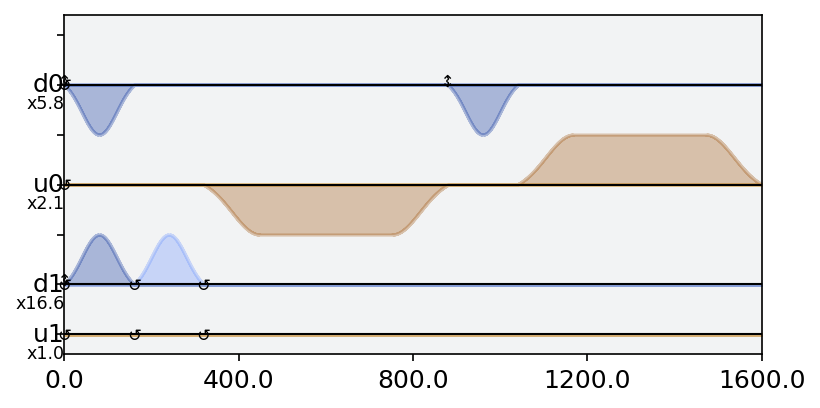

In [105]:
inst_map.get('cx', (0,1)).exclude(instruction_types=[pulse.SetFrequency]).draw(style=style)

### Run our refined CNOT

In [106]:
# We then schedule the output quantum circuit.
refined_custom_bell_sched = schedule(custom_bell_transpiled_qc, backend=backend, inst_map=inst_map)

In [107]:
refined_bell_job = execute([bell_sched, refined_custom_bell_sched], backend, meas_level=2, shots=512)

print(refined_bell_job.job_id())
job_monitor(refined_bell_job)

5f859a2b471ef10019c0eaf3
Job Status: job has successfully run


### How do we do now?

In [108]:
from qiskit.result.utils import marginal_counts

refined_bell_result = marginal_counts(refined_bell_job.result(), indices=qubits)

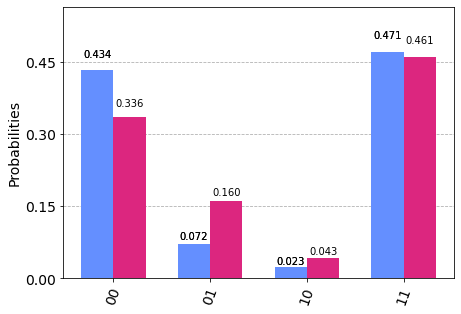

In [109]:
from qiskit.visualization import plot_histogram

bell_orig = refined_bell_result.get_counts(0)
refined_bell_new = refined_bell_result.get_counts(1)
plot_histogram([bell_orig, refined_bell_new])

### Thats more like it!

# Conclusion and summary
- Gates and measurements are implemented with pulses
    - In superconducting hardware these are microwave pulses
- Timing is important at the level of circuits and pulses
- The complicated physics of the pulse model are hidden by the circuit model
- Much more control at the pulse level, eg., define your own basis gateset as we did today.

## Where would I take this next?
- Use DRAG pulses instead of gaussian pulses
- Characterize our basis gateset using randomized benchmarking
- Investigate new calibration techniques for our pulses
- Add dynamical decoupling to further enhance the performance of our circuit and decouple our qubits from the environment
- Add new efficient entangling gates to our basis gateset.

## Exercise #2
We have now tuned up a basis gate set for the first two qubits in our backend. However, we skipped over how the measurement itself would be calibrated and what the measurement results look like.

First we save the current state of our chip below:

In [110]:
chip.save('saved_chip_ex2.json')

Head to [Exercise #2 - Calibrating a Qubit Measurement](./Exercise%20%232%20-%20Calibrating%20A%20Qubit%20Measurement.ipynb) to complete the exercise for this session.

In [111]:
%qiskit_copyright

In [112]:
%qiskit_version_table

In [113]:
from qiskit.circuit.equivalence import Key

def reset_equivalence_library():
    entry = StandardEquivalenceLibrary._map[(Key('h', 1))]
    
    equivs = entry.equivalences
    for i in range(len(equivs)-1):
        equivs.pop()

In [114]:
reset_equivalence_library()